# Problem 1

## Gillespie's Algorithm

### Imports and Helper Functions

In [250]:
import numpy as np
import matplotlib.pyplot as plt
import time
import copy
from scipy.integrate import solve_ivp

def standardize_timesteps(data: list[list[float]], data_rate: float, max_t: int) -> np.ndarray:
    t_list = np.array(data[0])
    new_t_list = np.linspace(0, max_t, data_rate * max_t)
    result = np.zeros((len(data), len(new_t_list)))
    result[0] = new_t_list
    for i in range(1, len(data)):
        result[i] = np.interp(new_t_list, t_list, data[i])

    return result

### Classes

In [251]:
class Population:
    def __init__(self, initial_X, initial_Y, initial_Z):
        self.X = initial_X
        self.Y = initial_Y
        self.Z = initial_Z

    def __str__(self):
        return f"X = {self.X}, Y = {self.Y}, Z = {self.Z}"

    def N(self):
        return self.X + self.Y + self.Z
    
    def tuple(self):
        return (self.X, self.Y, self.Z)

class Gillespie_Parameters:
    def __init__(self, population_size, initial_infected, beta, gamma, mu, delta=0):
        self.population = Population(population_size - initial_infected, initial_infected, 0)
        self.beta = beta
        self.gamma = gamma
        self.mu = mu
        self.delta = delta
        self.r0 = beta / (gamma + mu)

    def __str__(self):
        return f"r0 = {self.r0:.2f}, beta = {self.beta}, gamma = {self.gamma}, mu = {self.mu}, delta = {self.delta}, N = {self.population.N()}"

class Event:
    def __init__(self, name, rate_function, result_function):
        self.name = name
        self.rate_function = rate_function
        self.result_function = result_function

    def get_rate(self, params: Gillespie_Parameters):
        return self.rate_function(params)
    
    def execute_result(self, population: Population):
        return self.result_function(population)

### Define the events

In [252]:
def _birth_rate(params: Gillespie_Parameters):
    return params.mu * params.population.N()
def _birth_result(pop: Population) -> Population:
    pop.X += 1
BirthEvent = Event('birth', _birth_rate, _birth_result)

def _transmission_rate(params: Gillespie_Parameters):
    return params.beta * params.population.X * params.population.Y / params.population.N()
def _transmission_result(pop: Population) -> Population:
    pop.X -= 1
    pop.Y += 1
TransmissionEvent = Event('transmission', _transmission_rate, _transmission_result)

def _recovery_rate(params: Gillespie_Parameters):
    return params.gamma * params.population.Y
def _recovery_result(pop: Population) -> Population:
    pop.Y -= 1
    pop.Z += 1
RecoveryEvent = Event('recovery', _recovery_rate, _recovery_result)

def _death_x_rate(params: Gillespie_Parameters):
    return params.mu * params.population.X
def _death_x_result(pop: Population) -> Population:
    pop.X -= 1
DeathXEvent = Event('death_x', _death_x_rate, _death_x_result)

def _death_y_rate(params: Gillespie_Parameters):
    return params.mu * params.population.Y
def _death_y_result(pop: Population) -> Population:
    pop.Y -= 1
DeathYEvent = Event('death_y', _death_y_rate, _death_y_result)

def _death_z_rate(params: Gillespie_Parameters):
    return params.mu * params.population.Z
def _death_z_result(pop: Population) -> Population:
    pop.Z -= 1
DeathZEvent = Event('death_z', _death_z_rate, _death_z_result)

def _import_rate(params: Gillespie_Parameters):
    return params.delta * np.sqrt(params.population.N())
def _import_result(pop: Population) -> Population:
    pop.Y += 1
ImportEvent = Event('import', _import_rate, _import_result)

events = [BirthEvent, TransmissionEvent, RecoveryEvent, DeathXEvent, DeathYEvent, DeathZEvent]

### Prepare Gillespie Simulation

In [ ]:
class Result:
    def __init__(self, results: np.ndarray):
        self.t = results[0]
        self.X = results[1]
        self.Y = results[2]
        self.Z = results[3]

    def s_i_covariance(self):
        return np.cov(self.X, self.Y)[0][1]

class Results:
    def __init__(self, results: list[Result]):
        if len(results) == 0:
            raise ValueError('Results must have at least one result')
        for r in results:
            if r.t[0] != results[0].t[0]:
                raise ValueError('All results must have the same timesteps')
        self.t = results[0].t
        self.Xs = np.array([r.X for r in results])
        self.Ys = np.array([r.Y for r in results])
        self.Zs = np.array([r.Z for r in results])
    
    def add_result(self, result: Result):
        if result.t[0] != self.t[0]:
            raise ValueError('All results must have the same timesteps')
        self.Xs = np.append(self.Xs, result.X)
        self.Ys = np.append(self.Ys, result.Y)
        self.Zs = np.append(self.Zs, result.Z)

    def mean_result(self):
        return Result(np.array([self.t, np.mean(self.Xs, axis=0), np.mean(self.Ys, axis=0), np.mean(self.Zs, axis=0)]))

    def mean_and_std_infected(self):
        return np.mean(self.Ys, axis=0), np.std(self.Ys, axis=0)
    
    def mean_and_minmax_infected(self):
        minmax = np.zeros((2, len(self.t)))
        minmax[0] = np.min(self.Ys, axis=0)
        minmax[1] = np.max(self.Ys, axis=0)
        return np.mean(self.Ys, axis=0), minmax

def get_rates(events: list[Event], params: Gillespie_Parameters):
    return [e.get_rate(params) for e in events]

def get_delta_ts(rates: list[float]):
    rands = np.random.rand(len(rates))
    while 0 in rands: # avoid zeros
        rands = np.random.rand(len(rates))
    delta_ts = np.full(len(rates), np.inf)
    for i, r in enumerate(rates):
        if r == 0:
            continue
        delta_ts[i] = (-1 / r) * np.log(rands[i])
    return delta_ts


def gillespie(params: Gillespie_Parameters, events: list[Event], t_max) -> list[list[float]]:
    t = 0.0
    params
    results = [[], [], [], []] # t, X, Y, Z
    pop = copy.deepcopy(params.population)
    while t < t_max and params.population.N() > 0:
        y_prev = params.population.Y
        rates = get_rates(events, params)
        delta_ts = get_delta_ts(rates)
        event_index = np.argmin(delta_ts)
        t += delta_ts[event_index]
        events[event_index].execute_result(params.population)
        if params.population.Y == 0 and y_prev != 0:
            print(f'Extinction at t={t:.2f}')
        results[0].append(t)
        results[1].append(params.population.X)
        results[2].append(params.population.Y)
        results[3].append(params.population.Z)
        # print(f'{events[event_index].name} at t={t}, N={params.population.N()}')
    params.population = pop
    return results

class Experiment:
    def __init__(self, params: Gillespie_Parameters, events: list[Event], simulation_length: int, data_rate=1, iterations=1):
        self.params = params
        self.events = events
        self.simulation_length = simulation_length
        self.data_rate = data_rate
        self.iterations = iterations

    def run(self):
        print(f'Running experiment: {str(self.params)}, {self.iterations} iterations')
        self.raw_results = []
        standardized_results = []
        for i in range(self.iterations):
            start = time.perf_counter()
            raw_result = gillespie(self.params, self.events, self.simulation_length)
            self.raw_results.append(raw_result)
            standardized_results.append(Result(standardize_timesteps(raw_result, self.data_rate, self.simulation_length)))
            end = time.perf_counter()
            print(f'Ran iteration {i+1} in {(end - start):.2f} seconds')
        self.results = Results(standardized_results)
        return self.results
    
    def integrate_deterministic_sir(self, deterministic_sir_function):
        return solve_ivp(
            deterministic_sir_function,
            (0, self.simulation_length),
            self.params.population.tuple(),
            t_eval=np.linspace(0, self.simulation_length, self.simulation_length * self.data_rate),
            args=(self.params.beta, self.params.gamma, self.params.mu))
    
class Experiments:
    def __init__(self, experiments: list[Experiment]):
        self.experiments = experiments

    def run(self):
        for e in self.experiments:
            e.run()

### Run Gillespie

Running experiment: r0 = 4.55, beta = 0.5, gamma = 0.1, mu = 0.01, delta = 0, N = 10000.0, 1 iterations
Ran iteration 1 in 1.27 seconds


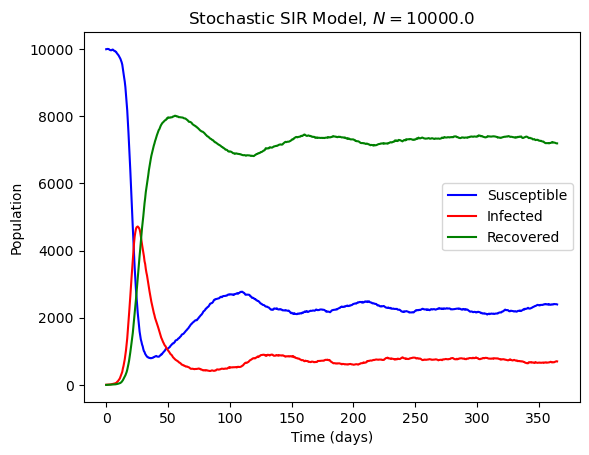

In [254]:
population_size = 1e4
initial_infected = 5
sim_length = 365
data_rate = 2
beta = 0.5
gamma = 0.1
mu = 1/100
delta = 0.02

experiment1 = Experiment(Gillespie_Parameters(population_size=population_size, initial_infected=initial_infected, beta=beta, gamma=gamma, mu=mu), events=events, simulation_length=sim_length, data_rate=data_rate)

r0 = beta / (gamma + mu)

res = experiment1.run().mean_result()

plt.plot(res.t, res.X, 'b', label='Susceptible')
plt.plot(res.t, res.Y, 'r', label='Infected')
plt.plot(res.t, res.Z, 'g', label='Recovered')
plt.legend(loc='right')
plt.xlabel('Time (days)')
plt.ylabel('Population')
plt.title(f'Stochastic SIR Model, $N={population_size}$')
plt.show()

# Compare to deterministic model

Running experiment: r0 = 4.55, beta = 0.5, gamma = 0.1, mu = 0.01, delta = 0, N = 1000.0, 1 iterations
Ran iteration 1 in 0.14 seconds
Running experiment: r0 = 4.55, beta = 0.5, gamma = 0.1, mu = 0.01, delta = 0, N = 10000.0, 1 iterations
Ran iteration 1 in 1.20 seconds
Running experiment: r0 = 4.55, beta = 0.5, gamma = 0.1, mu = 0.01, delta = 0, N = 100000.0, 1 iterations
Ran iteration 1 in 12.14 seconds
Running experiment: r0 = 4.55, beta = 0.5, gamma = 0.1, mu = 0.01, delta = 0, N = 1000000.0, 1 iterations
Ran iteration 1 in 121.21 seconds


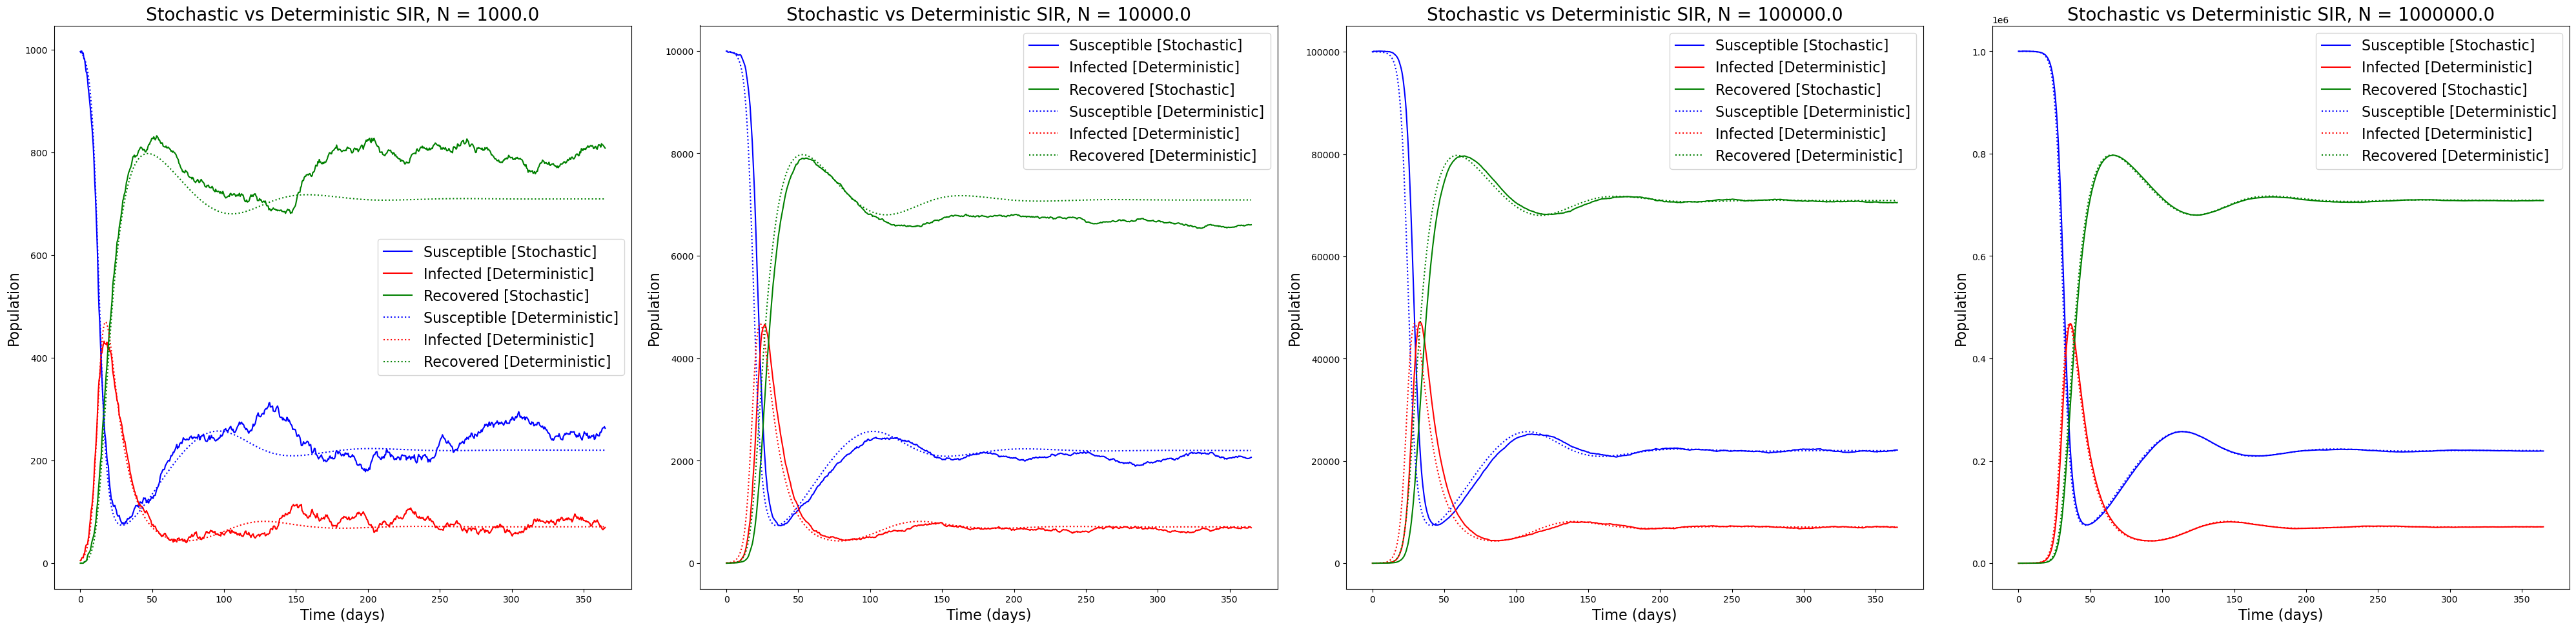

In [296]:
def deterministic_sir(t, xyz, beta, gamma, mu):
    x, y, z = xyz
    n = x + y + z
    dxdt = mu * n - beta * (x/n) * y - mu * x
    dydt = beta * (x/n) * y - gamma * y - mu * y
    dzdt = gamma * y - mu * z
    return [dxdt, dydt, dzdt]

ns = [1e3, 1e4, 1e5, 1e6]
fig, ax = plt.subplots(1, 4, figsize=(40, 10))
for i, n in enumerate(ns):
    params = Gillespie_Parameters(population_size=n, initial_infected=initial_infected, beta=0.5, gamma=0.1, mu=0.01)
    experiment = Experiment(params, events, sim_length, data_rate=data_rate)
    res = experiment.run().mean_result()
    sol = experiment.integrate_deterministic_sir(deterministic_sir)

    ax[i].plot(res.t, res.X, 'b', label='Susceptible [Stochastic]')
    ax[i].plot(res.t, res.Y, 'r', label='Infected [Deterministic]')
    ax[i].plot(res.t, res.Z, 'g', label='Recovered [Stochastic]')
    ax[i].plot(sol.t, sol.y[0], 'b:', label='Susceptible [Deterministic]')
    ax[i].plot(sol.t, sol.y[1], 'r:', label='Infected [Deterministic]')
    ax[i].plot(sol.t, sol.y[2], 'g:', label='Recovered [Deterministic]')
    ax[i].legend(fontsize=16)
    ax[i].set_title(f'Stochastic vs Deterministic SIR, N = {n}', fontsize=20)
    ax[i].set_xlabel('Time (days)', fontsize=16)
    ax[i].set_ylabel('Population', fontsize=16)

plt.tight_layout()
plt.show()

## Vary Gillespie parameters

### Vary $R_0$ 

In [285]:
r0s = np.arange(0.5, 15.5, 0.5)
iterations = 20

r0experiments = Experiments([])
for r0 in r0s:
    r0experiments.experiments.append(Experiment(Gillespie_Parameters(population_size, initial_infected, beta=r0 * (gamma + mu), gamma=gamma, mu=mu), events, sim_length, data_rate, iterations))
r0experiments.run()

Running experiment: r0 = 0.50, beta = 0.055, gamma = 0.1, mu = 0.01, delta = 0, N = 10000.0, 20 iterations
Extinction at t=45.557751012028184
Ran iteration 1 in 0.60 seconds
Extinction at t=12.05007525973454
Ran iteration 2 in 0.52 seconds
Extinction at t=46.8029483573607
Ran iteration 3 in 0.54 seconds
Extinction at t=88.14386254782397
Ran iteration 4 in 0.55 seconds
Extinction at t=59.227404181315855
Ran iteration 5 in 0.53 seconds
Extinction at t=28.182926736437626
Ran iteration 6 in 0.50 seconds
Extinction at t=55.25123649609899
Ran iteration 7 in 0.53 seconds
Extinction at t=19.731693496773197
Ran iteration 8 in 0.53 seconds
Extinction at t=12.877078285285297
Ran iteration 9 in 0.49 seconds
Extinction at t=49.773981807664235
Ran iteration 10 in 0.52 seconds
Extinction at t=9.375311792163568
Ran iteration 11 in 0.49 seconds
Extinction at t=64.36092964914573
Ran iteration 12 in 0.52 seconds
Extinction at t=17.012778977936588
Ran iteration 13 in 0.51 seconds
Extinction at t=14.015043

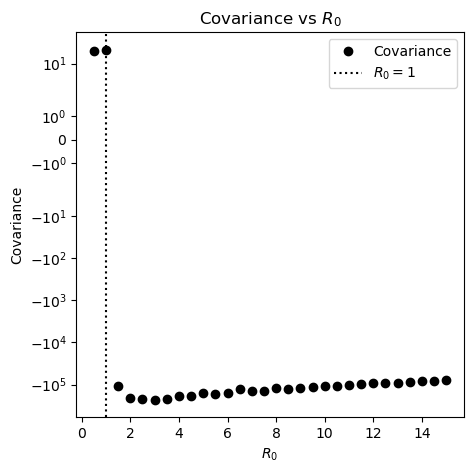

In [286]:
# plot covariance

plt.figure(figsize=(5,5))
plt.title('Covariance vs $R_0$')
plt.xlabel('$R_0$')
plt.ylabel('Covariance')
plt.yscale('symlog')

covs = []
for ex in r0experiments.experiments:
    mean = ex.results.mean_result()
    covs.append(mean.s_i_covariance())
plt.plot(r0s, covs, 'ko', label='Covariance')
plt.axvline(1, color='k', linestyle=':', label='$R_0=1$')
plt.legend()
plt.show()

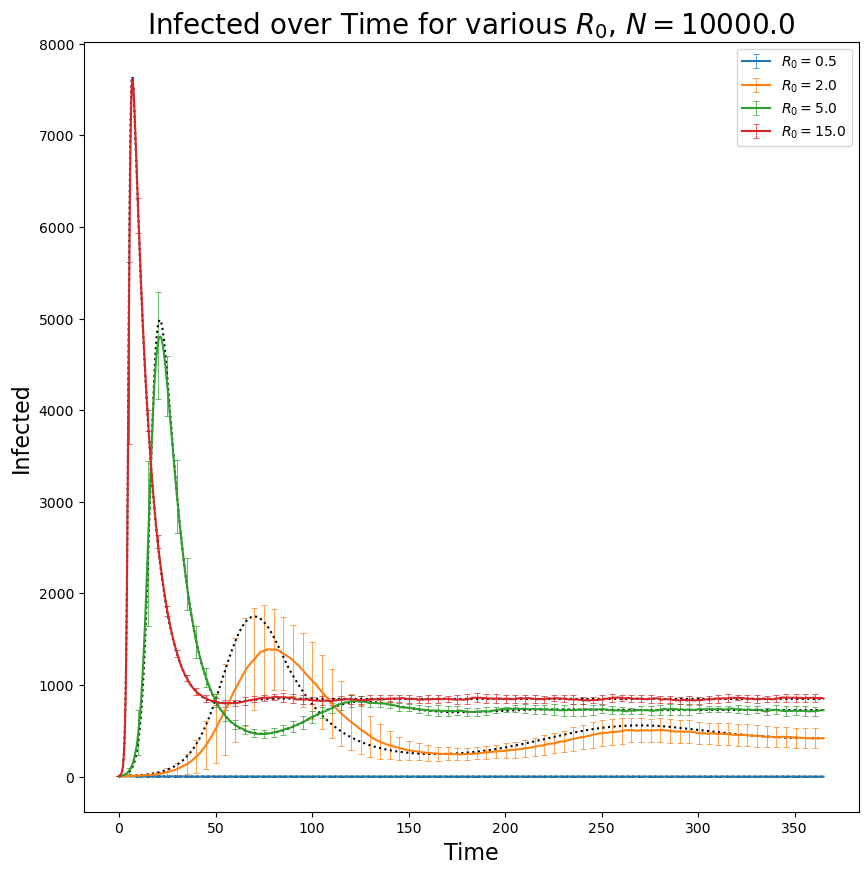

In [287]:
graphed_r0s = [0.5, 2.0, 5.0, 15.0]
plt.figure(figsize=(10, 10))
for ex in r0experiments.experiments:
    if ex.params.r0 not in graphed_r0s:
        continue
    mean, err = ex.results.mean_and_std_infected()
    plt.errorbar(ex.results.t, mean, yerr=err, errorevery=10, capsize=2, elinewidth=0.5, capthick=0.5, label=f"$R_0={ex.params.r0}$")
    det = ex.integrate_deterministic_sir(deterministic_sir)
    plt.plot(det.t, det.y[1], 'k:')
plt.xlabel("Time", fontsize=16)
plt.ylabel("Infected", fontsize=16)
plt.title(f'Infected over Time for various $R_0$, $N={population_size}$' , fontsize=20)
plt.legend()
plt.show()

### Varying $\gamma$

In [288]:
gammas = np.arange(0.05, 1.05, 0.05)
iterations = 20
r0 = 5.0

gamma_experiments = Experiments([])
for g in gammas:
    gamma_experiments.experiments.append(Experiment(Gillespie_Parameters(population_size, initial_infected, beta=beta, gamma=g, mu=mu), events, sim_length, data_rate, iterations))
gamma_experiments.run()

Running experiment: r0 = 8.33, beta = 0.5, gamma = 0.05, mu = 0.01, delta = 0, N = 10000.0, 20 iterations
Ran iteration 1 in 1.29 seconds
Ran iteration 2 in 1.43 seconds
Ran iteration 3 in 1.26 seconds
Ran iteration 4 in 1.32 seconds
Ran iteration 5 in 1.33 seconds
Ran iteration 6 in 1.39 seconds
Ran iteration 7 in 1.30 seconds
Ran iteration 8 in 1.33 seconds
Ran iteration 9 in 1.32 seconds
Ran iteration 10 in 1.29 seconds
Ran iteration 11 in 1.36 seconds
Ran iteration 12 in 1.31 seconds
Ran iteration 13 in 1.36 seconds
Ran iteration 14 in 1.27 seconds
Ran iteration 15 in 1.30 seconds
Ran iteration 16 in 1.32 seconds
Ran iteration 17 in 1.35 seconds
Ran iteration 18 in 1.41 seconds
Ran iteration 19 in 1.33 seconds
Ran iteration 20 in 1.37 seconds
Running experiment: r0 = 4.55, beta = 0.5, gamma = 0.1, mu = 0.01, delta = 0, N = 10000.0, 20 iterations
Ran iteration 1 in 1.31 seconds
Ran iteration 2 in 1.32 seconds
Ran iteration 3 in 1.30 seconds
Ran iteration 4 in 1.35 seconds
Ran iterat

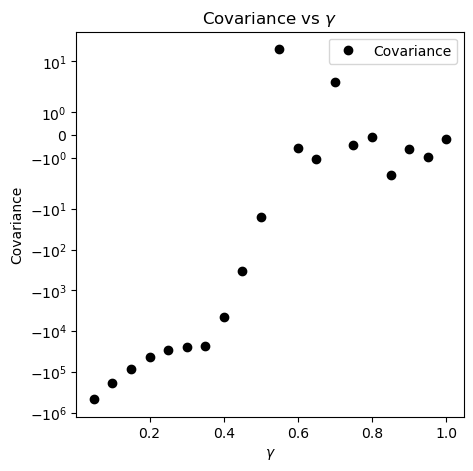

In [289]:
# plot covariance

plt.figure(figsize=(5,5))
plt.title('Covariance vs $\gamma$')
plt.xlabel('$\gamma$')
plt.ylabel('Covariance')
plt.yscale('symlog')

covs = []
for ex in gamma_experiments.experiments:
    mean = ex.results.mean_result()
    covs.append(mean.s_i_covariance())
plt.plot(gammas, covs, 'ko', label='Covariance')
plt.legend()
plt.show()

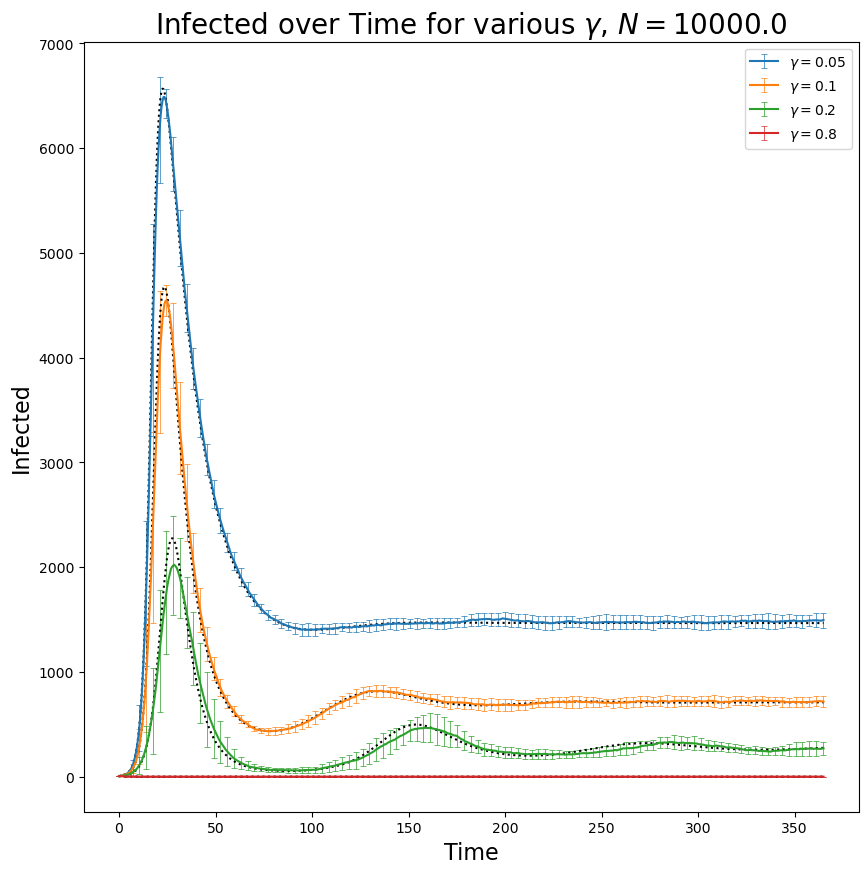

In [290]:
graphed_gammas = [0.05, 0.1, 0.2, 0.8]

plt.figure(figsize=(10, 10))
for ex in gamma_experiments.experiments:
    if ex.params.gamma not in graphed_gammas:
        continue
    mean, err = ex.results.mean_and_std_infected()
    errbar = plt.errorbar(ex.results.t, mean, yerr=err, errorevery=7, capsize=2, elinewidth=0.5, capthick=0.5, label=f"$\gamma={ex.params.gamma}$")
    det = ex.integrate_deterministic_sir(deterministic_sir)
    plt.plot(det.t, det.y[1], 'k:')
plt.xlabel("Time", fontsize=16)
plt.ylabel("Infected", fontsize=16)
plt.title(f'Infected over Time for various $\\gamma$, $N={population_size}$', fontsize=20)
plt.legend()
plt.show()

### Varying N

In [293]:
ns = [1e3, 5e3, 1e4, 5e4, 1e5]
iterations = 20
r0 = 5.0

n_experiments = Experiments([])
for n in ns:
    n_experiments.experiments.append(Experiment(Gillespie_Parameters(n, initial_infected, beta=beta, gamma=gamma, mu=mu), events, sim_length, data_rate, iterations))
n_experiments.run()

Running experiment: r0 = 4.55, beta = 0.5, gamma = 0.1, mu = 0.01, delta = 0, N = 1000.0, 20 iterations
Ran iteration 1 in 0.16 seconds
Ran iteration 2 in 0.13 seconds
Ran iteration 3 in 0.13 seconds
Ran iteration 4 in 0.13 seconds
Ran iteration 5 in 0.13 seconds
Ran iteration 6 in 0.13 seconds
Ran iteration 7 in 0.12 seconds
Ran iteration 8 in 0.12 seconds
Ran iteration 9 in 0.12 seconds
Ran iteration 10 in 0.14 seconds
Ran iteration 11 in 0.14 seconds
Ran iteration 12 in 0.13 seconds
Ran iteration 13 in 0.13 seconds
Ran iteration 14 in 0.14 seconds
Ran iteration 15 in 0.12 seconds
Ran iteration 16 in 0.13 seconds
Ran iteration 17 in 0.14 seconds
Ran iteration 18 in 0.12 seconds
Ran iteration 19 in 0.12 seconds
Ran iteration 20 in 0.12 seconds
Running experiment: r0 = 4.55, beta = 0.5, gamma = 0.1, mu = 0.01, delta = 0, N = 5000.0, 20 iterations
Ran iteration 1 in 0.61 seconds
Ran iteration 2 in 0.63 seconds
Ran iteration 3 in 0.63 seconds
Ran iteration 4 in 0.63 seconds
Ran iteration

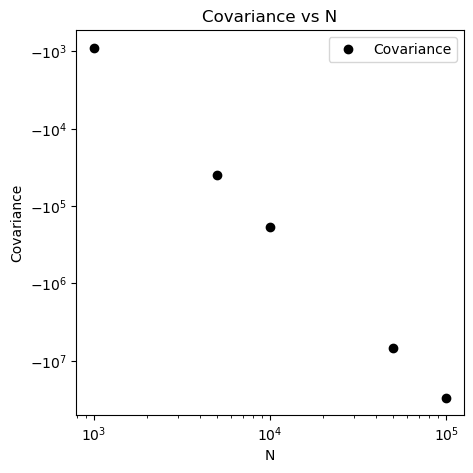

In [294]:
# plot covariance

plt.figure(figsize=(5,5))
plt.title('Covariance vs N')
plt.xlabel('N')
plt.ylabel('Covariance')
plt.yscale('symlog')
plt.xscale('log')

covs = []
for ex in n_experiments.experiments:
    mean = ex.results.mean_result()
    covs.append(mean.s_i_covariance())
plt.plot(ns, covs, 'ko', label='Covariance')
plt.legend()
plt.show()

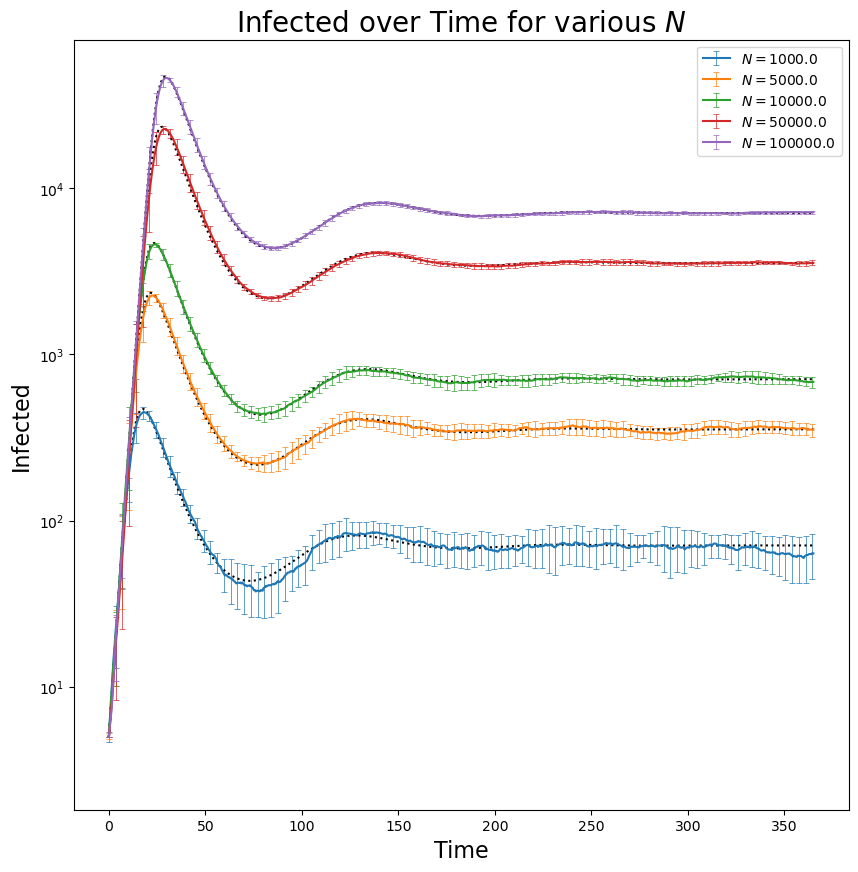

In [295]:
plt.figure(figsize=(10, 10))
plt.yscale('symlog')
for ex in n_experiments.experiments:
    mean, err = ex.results.mean_and_std_infected()
    plt.errorbar(ex.results.t, mean, yerr=err, errorevery=7, capsize=2, elinewidth=0.5, capthick=0.5, label=f"$N={ex.params.population.N()}$")
    det = ex.integrate_deterministic_sir(deterministic_sir)
    plt.plot(det.t, det.y[1], 'k:')
plt.xlabel("Time", fontsize=16)
plt.ylabel("Infected", fontsize=16)
plt.title(f'Infected over Time for various $N$', fontsize=20)
plt.legend()
plt.show()